In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import pydrake
from pydrake.all import (
    PiecewisePolynomial, RigidTransform, RotationMatrix, JacobianWrtVariable
)

from src.drake_helpers import (
    BuildAndSimulateTrajectory, 
    setup_manipulation_station,
    visualize_transform,
    GripperControllerUsingIiwaState,
    GripperControllerUsingIiwaStateV2,
)
from src.ik import (
    create_q_knots, 
    pose_to_jointangles, 
    jointangles_to_pose, 
    spatial_velocity_jacobian_at_jointangles,
)
from src.throw import (
    plan_pickup,
    plan_prethrow_pose,
    add_go_to_ja_via_jointinterpolation,
    add_go_to_pose_via_jointinterpolation,
    plan_throw,
)
from src.trajectory import get_launch_speed_required

# cleaner debugging
np.set_printoptions(precision=3, suppress=True)

In [2]:
# start a single meshcat server instance to use for remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=[])
print(web_url)

http://127.0.0.1:7023/static/


## Define where the object will appear and how to grasp it

In [3]:
'''
setup
'''
# https://schunk.com/fileadmin/pim/docs/IM0026091.PDF
# going off the datasheets, this is approximately correct. from body frame vizd to somewhere near but not at the end of the gripper
gripper_body_to_grasp_body = 0.101 # meters

# target 
P_WORLD_TARGET = np.array([-4, 4, -1])
T_world_target = RigidTransform(RotationMatrix(), P_WORLD_TARGET)

# object pose setup and initial grasp
T_defaultObj_preferredObj = RigidTransform(
    p=[0, 0, 0.09],
    #R=RotationMatrix.MakeXRotation(-np.pi/2.0).multiply(RotationMatrix.MakeYRotation(-np.pi / 2))
    R=RotationMatrix()
)
T_world_objectInitial = RigidTransform(
    p=[0, -.6, 0.0],
    R=RotationMatrix() 
).multiply(T_defaultObj_preferredObj)

rod_length = 0.4
T_obj_grasp = RigidTransform(
    #p=[0, -0.15, 0.0], #topdown
    #R=RotationMatrix.MakeZRotation(0).multiply(RotationMatrix.MakeYRotation(-np.pi / 2)) #topdown
#     p=[(np.random.rand() - 0.5) * rod_length, 0.0, 0.025 + gripper_body_to_grasp_body], #fromtheside
    p=[-rod_length / 2 + 0.05 , 0.0, 0.025 + gripper_body_to_grasp_body], #fromtheside
    R=RotationMatrix.MakeXRotation(-np.pi / 2).multiply(RotationMatrix.MakeYRotation(-np.pi / 2)) #fromtheside
)
T_world_grasp = T_world_objectInitial.multiply(T_obj_grasp)

# Get initial pose of the gripper by using default context of manip station.
T_world_robotInitial, meshcat = setup_manipulation_station(T_world_objectInitial, zmq_url, T_world_target, obj_str="rod")

# viz for sanity check
visualize_transform(meshcat, "T_world_obj0", T_world_objectInitial)
visualize_transform(meshcat, "T_world_grasp", T_world_grasp)
T_world_target = RigidTransform(
    p=P_WORLD_TARGET,
    R=RotationMatrix()
)
visualize_transform(meshcat, "target", T_world_target)

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6023...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7023/static/
Connected to meshcat-server.


## The next cell determines everything relevant to the throw

In [4]:
'''
throw
* heading (top down view of the xy plane, relative to the positive x axis)
* release angle (relative to azimuth)
* release velocity
'''
print(f"-------Planning throw-------")
throw_heading = np.arctan2(P_WORLD_TARGET[1], P_WORLD_TARGET[0])

# we need these states to calculate the jacobian
ja1 = throw_heading - np.pi
# you can play around with these to achieve different "release" poses
prethrow_ja = np.array([ja1, 0, 0, 2.00, 0, -1.8, 0, 0, 0])
throwend_ja = np.array([ja1, 0, 0, 0.9, 0, -0.9, 0, 0, 0])
release_ja = prethrow_ja + 0.5 * (throwend_ja - prethrow_ja)
T_world_releasePose = jointangles_to_pose(release_ja[:7])
T_world_prethrowPose = jointangles_to_pose(prethrow_ja[:7])
print(f"Release joint angles: {release_ja}")

# calculate jacobian at release 
J_G = spatial_velocity_jacobian_at_jointangles(
    jointangles=release_ja[:7],
    gripper_to_object_dist=gripper_body_to_grasp_body
)
J_G_joint4 = J_G[3:, 3] # spatial velocity only
J_G_joint6 = J_G[3:, 5] # spatial velocity only
J_G_joints46 = np.zeros((3, 2))
J_G_joints46[:, 0] = J_G_joint4
J_G_joints46[:, 1] = J_G_joint6
print(J_G_joints46)

# calculate angle at release
release_spatial_dir = J_G_joints46 @ (throwend_ja - prethrow_ja)[[3, 5]]
print(f"Release spatial direction: {release_spatial_dir}")
angle_above_plane_rads = np.arctan2(
    release_spatial_dir[2],
    np.linalg.norm(release_spatial_dir[:2])
)
print(f"Throw angle (above xy plane) degs: {angle_above_plane_rads * 180.0 / np.pi}")

# calculate required release velocity magnitude
p_release = (
    T_world_releasePose.translation()
  + T_world_releasePose.rotation().multiply([0, gripper_body_to_grasp_body, 0])
)
T_world_objReleasePose = RigidTransform(
    T_world_releasePose.rotation(),
    T_world_releasePose.translation() + T_world_releasePose.rotation().multiply([0, gripper_body_to_grasp_body, 0])
)
visualize_transform(meshcat, "T_world_releasePose", T_world_releasePose)
visualize_transform(meshcat, "T_world_objReleasePose", T_world_objReleasePose)

delta_x = np.linalg.norm(P_WORLD_TARGET[:2]) - np.linalg.norm(p_release[:2]) # dist on xy plane
delta_y = P_WORLD_TARGET[2] - p_release[2] # height difference
mag_v0_reqd = get_launch_speed_required(theta=angle_above_plane_rads, x=delta_x, y=delta_y)
mag_v0_reqd = mag_v0_reqd
print(f"Initial velocity magnitude: {mag_v0_reqd}")

# calculate required time for throw motion
time_reqd = np.linalg.norm(release_spatial_dir) / mag_v0_reqd
print(f"time required: {time_reqd}")

'''
timings
'''
t_goToObj = 1.0
t_holdObj = 0.5
t_goToPreobj = 1.0
t_goToWaypoint = 3.0
t_goToPrethrow = 10.0 # must be greater than 1.0 for a 1 second hold to stabilize
t_goToThrowEnd = time_reqd 

-------Planning throw-------
Release joint angles: [-0.785  0.     0.     1.45   0.    -1.35   0.     0.     0.   ]
[[ 0.163 -0.197]
 [-0.163  0.197]
 [-0.496  0.099]]
Release spatial direction: [-0.356  0.356  0.634]
Throw angle (above xy plane) degs: 51.5325191324041
Initial velocity magnitude: 6.494298449062825
time required: 0.12473010389843081


# Generate trajectories in joint angle space with timings from above

### End-effector trajectory

In [5]:
# plan pickup
t_lst, q_knots, total_time = plan_pickup(T_world_robotInitial, T_world_grasp,
    t_goToObj=t_goToObj,
    t_holdObj=t_holdObj,
    t_goToPreobj=t_goToPreobj
)

# clear the bins via a waypoint
T_world_hackyWayPoint = RigidTransform(
    p=[-.6, -0.0, 0.6],
    R=RotationMatrix.MakeXRotation(-np.pi/2.0), #R_WORLD_PRETHROW, #RotationMatrix.MakeXRotation(-np.pi/2.0),
)
t_lst, q_knots = add_go_to_pose_via_jointinterpolation(
    T_world_robotInitial, 
    T_world_hackyWayPoint, 
    t_start=total_time,
    t_lst=t_lst,
    q_knots=q_knots,
    time_interval_s=t_goToWaypoint
)

# go to prethrow
t_lst, q_knots = add_go_to_ja_via_jointinterpolation(
    pose_to_jointangles(T_world_hackyWayPoint), 
    prethrow_ja, 
    t_start=total_time + t_goToWaypoint,
    t_lst=t_lst,
    q_knots=q_knots,
    time_interval_s=t_goToPrethrow,
    hold_time_s=1.0,
)

# go to throw
t_lst, q_knots = add_go_to_ja_via_jointinterpolation(
    prethrow_ja,
    throwend_ja,
    t_start=total_time + t_goToWaypoint + t_goToPrethrow,
    t_lst=t_lst,
    q_knots=q_knots,
    time_interval_s=t_goToThrowEnd,
    num_samples=5,
    include_end=True
)

# turn trajectory into joint space
q_knots = np.array(q_knots)
q_traj = PiecewisePolynomial.CubicShapePreserving(t_lst, q_knots[:, 0:7].T)

### Gripper trajectory

In [6]:
# make gripper trajectory
delay_hack = 0.00
gripper_times_lst = np.array([
    0.,
    t_goToObj,
    t_holdObj,
    t_goToPreobj,
    t_goToWaypoint,
    t_goToPrethrow,
    t_goToThrowEnd / 2.0 + delay_hack, # should be some portion of t_goToThrowEnd
    1e-9,
    t_goToThrowEnd / 2.0 - delay_hack, # should be some portion of t_goToThrowEnd
])
gripper_cumulative_times_lst = np.cumsum(gripper_times_lst)
GRIPPER_OPEN = 0.5
GRIPPER_CLOSED = 0.0
gripper_knots = np.array([
    GRIPPER_OPEN,
    GRIPPER_OPEN,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_CLOSED,
    GRIPPER_OPEN,
    GRIPPER_OPEN,
]).reshape(1, gripper_times_lst.shape[0])
g_traj = PiecewisePolynomial.FirstOrderHold(gripper_cumulative_times_lst, gripper_knots)

### Visualizing trajectories

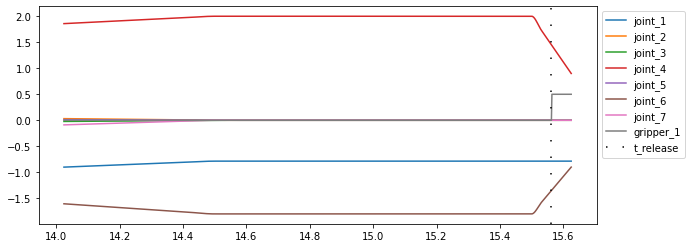

In [7]:
plt.figure(figsize=(10, 4))

viz_times = np.linspace(q_traj.end_time() - 1.6, q_traj.end_time(), 1000)
q_plan = np.hstack([q_traj.value(t) for t in viz_times])
g_plan = np.hstack([g_traj.value(t) for t in viz_times])

for idx, r in enumerate(q_plan):
    plt.plot(viz_times, r, label=f"joint_{idx + 1}")
for idx, r in enumerate(g_plan):
    plt.plot(viz_times, r, label=f"gripper_{idx + 1}")
    
plt.axvline(
    x=gripper_cumulative_times_lst[-2],
    color="black", linestyle=(0, (1, 10)), label="t_release"
);
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

# Run simulation

In [8]:
get_gripper_controller_1 = lambda station_plant: GripperControllerUsingIiwaState(
    plant=station_plant,
    T_world_objectPickup=T_world_grasp,
    T_world_prethrow=T_world_prethrowPose,
    T_world_targetRelease=T_world_releasePose,
    dbg_state_prints=True,
)

# doesn't release for the (-6, 6, -1)
get_gripper_controller_2 = lambda station_plant: GripperControllerUsingIiwaStateV2(
    plant=station_plant,
    gripper_to_object_dist=gripper_body_to_grasp_body,
    T_world_objectPickup=T_world_grasp,
    T_world_prethrow=T_world_prethrowPose,
    p_world_target=T_world_target.translation(),
    height_thresh=0.0, # tunable parameter
    dbg_state_prints=True
)

# do the thing
simulator, station_plant, meshcat, state_logger = BuildAndSimulateTrajectory(
    q_traj=q_traj,
    g_traj=g_traj,
    get_gripper_controller=get_gripper_controller_1,
    T_world_objectInitial=T_world_objectInitial, # where to init the object in the world
    T_world_targetBin=T_world_target, # where the ball should hit - aka where the bin will catch it
    zmq_url=zmq_url,
    time_step=1e-3, # target (-6, 6, -1). 1e-3 => overshoot barely, 1e-4 => undershoot barely, look around 7.92-7.94 s in sim
    obj_str="mustard"
)

visualize_transform(
    meshcat,
    "TARGET",
    RigidTransform(RotationMatrix.MakeZRotation(0), P_WORLD_TARGET),
    prefix='',
    length=0.3,
    radius=0.02
)

throw_time = 2
meshcat.start_recording()
print(f"Throw motion should happen from 15.5 seconds to {15.5 + time_reqd} seconds")
print(f"Running for {q_traj.end_time() + throw_time} seconds")
simulator.AdvanceTo(q_traj.end_time() + throw_time)
meshcat.stop_recording()
meshcat.publish_recording()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6023...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7023/static/
Connected to meshcat-server.
Throw motion should happen from 15.5 seconds to 15.62473010389843 seconds
Running for 17.62473010389843 seconds
ROBOT BECAME STATIONARY
ROBOT STARTED MOVING
ROBOT BECAME STATIONARY
WE REACHED THE PICKUP POINT
AT PICK UP + ROBOT IS STATIONARY
ROBOT STARTED MOVING
ROBOT BECAME STATIONARY
ROBOT STARTED MOVING
ROBOT BECAME STATIONARY
ROBOT STARTED MOVING
ROBOT BECAME STATIONARY
ROBOT STARTED MOVING
ROBOT BECAME STATIONARY
ROBOT STARTED MOVING
ROBOT BECAME STATIONARY
ROBOT STARTED MOVING
WE REACHED THE PRETHROW POINT
WE REACHED THE PRETHROW POINT
WE REACHED THE PRETHROW POINT
WE REACHED THE PRETHROW POINT
WE REACHED THE PRETHROW POINT
WE REACHED THE PRETHROW POINT
WE REACHED THE PRETHROW POINT
WE REACHED THE PRETHROW POINT
WE REACHED THE PRETHROW POINT
WE REACHED THE PRETHROW POINT
WE REACHED THE PRETHROW POINT


curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0.327  0.327  0.605]
curr: [-0.17   0.167  0.418] target: [-0

curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.17   0.419] target: [-0

curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.172  0.172  0.419] target: [-0

curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.172  0.419] target: [-0

curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0

curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0.327  0.327  0.605]
curr: [-0.173  0.173  0.419] target: [-0

curr: [-0.275  0.275  0.508] target: [-0.327  0.327  0.605]
curr: [-0.277  0.277  0.511] target: [-0.327  0.327  0.605]
curr: [-0.279  0.279  0.514] target: [-0.327  0.327  0.605]
curr: [-0.281  0.281  0.517] target: [-0.327  0.327  0.605]
curr: [-0.283  0.283  0.521] target: [-0.327  0.327  0.605]
curr: [-0.286  0.286  0.524] target: [-0.327  0.327  0.605]
curr: [-0.288  0.288  0.527] target: [-0.327  0.327  0.605]
curr: [-0.29   0.29   0.531] target: [-0.327  0.327  0.605]
curr: [-0.292  0.292  0.534] target: [-0.327  0.327  0.605]
curr: [-0.294  0.294  0.538] target: [-0.327  0.327  0.605]
curr: [-0.296  0.296  0.541] target: [-0.327  0.327  0.605]
curr: [-0.298  0.298  0.545] target: [-0.327  0.327  0.605]
curr: [-0.3    0.3    0.549] target: [-0.327  0.327  0.605]
curr: [-0.302  0.302  0.552] target: [-0.327  0.327  0.605]
curr: [-0.304  0.304  0.556] target: [-0.327  0.327  0.605]
curr: [-0.307  0.307  0.56 ] target: [-0.327  0.327  0.605]
curr: [-0.309  0.309  0.564] target: [-0

### Simulation visualization (+ comparison with plan)

Approx release time: 15.001


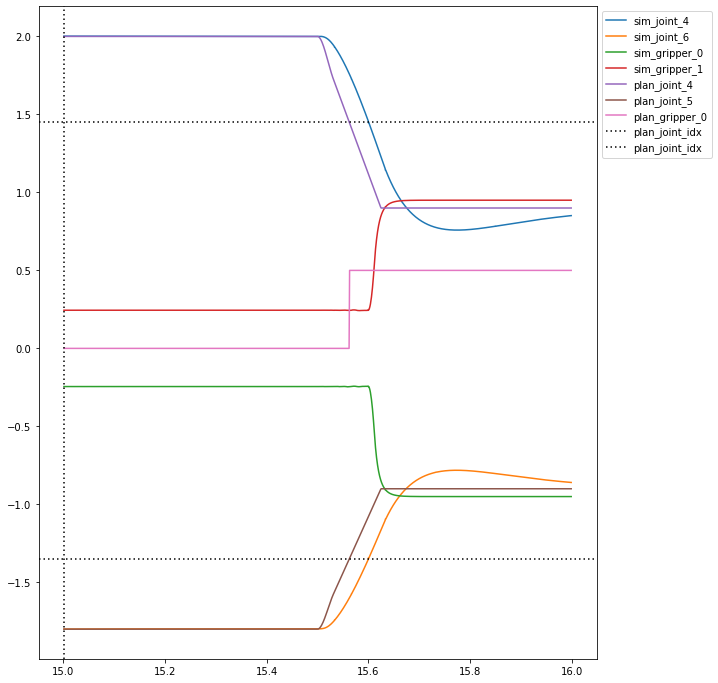

In [9]:
plt.figure(figsize=(10, 12))

all_log_times = state_logger.sample_times()
chosen_idxs = (15 < all_log_times) & (all_log_times < 16)

log_times = state_logger.sample_times()[chosen_idxs]
log_states = state_logger.data()[:, chosen_idxs]

for idx, r in enumerate(log_states[[10, 12]]):
    plt.plot(log_times, r, label=f"sim_joint_{2*idx+4}")
for idx, r in enumerate(log_states[[14, 15]]):
    plt.plot(log_times, 10 *r, label=f"sim_gripper_{idx}")
    
q_plan = np.hstack([q_traj.value(t) for t in log_times])
g_plan = np.hstack([g_traj.value(t) for t in log_times])
for idx, r in enumerate(q_plan[[3, 5]]):
    plt.plot(log_times, r, label=f"plan_joint_{idx + 4}")
for idx, r in enumerate(g_plan):
    plt.plot(log_times, r, label=f"plan_gripper_{idx}")

for idx in [4, 6]:
    plt.axhline(
        y=release_ja[idx-1],
        color="black", linestyle=(0, (1, 2)), label=f"plan_joint_idx"
    );

approx_release_idx = np.where(log_states[15] > log_states[15].min() + 1e-4)[0][0]
approx_release_time = log_times[approx_release_idx]
print(f"Approx release time: {approx_release_time}")
plt.axvline(
    x=approx_release_time,
    color="black", linestyle=(0, (1, 2)), label=""
);

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

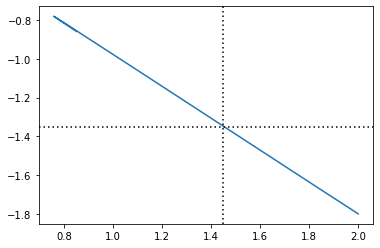

In [10]:
plt.plot(log_states[10], log_states[12]);
plt.axvline(
    x=release_ja[3],
    color="black", linestyle=(0, (1, 2))
);
plt.axhline(
    y=release_ja[5],
    color="black", linestyle=(0, (1, 2))
);

In [11]:
context = simulator.get_context()
station_plant.GetPositions(
    station_plant.GetMyContextFromRoot(context),
    station_plant.GetModelInstanceByName("sphere")
)

RuntimeError: There is no model instance named 'sphere' in the model.

## Plot trajectory of the object

In [ ]:
plt.figure(figsize=(10, 12))

all_obj_times = state_logger.sample_times()
obj_idxs = (-1 < all_log_times) & (all_log_times < 10)

obj_times = state_logger.sample_times()[obj_idxs]
obj_states = state_logger.data()[:, obj_idxs]

for idx, r in enumerate(obj_states[[0, 1, 2, 3, 4, 5, 6, 7]]):
    plt.plot(log_times, r, label=f"idx")

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);